<a href="https://colab.research.google.com/github/pravalika3986/FMML_MODULES/blob/main/Module_7_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Module 7 Project: Movie Recommendation Engine

`Module Coordinator: Ganesh Chandan`

In this module, we will try to create a Movie Recommendation System using different unsupervised learning techniques.

In [1]:
# dataset download

# !wget https://files.grouplens.org/datasets/movielens/ml-100k.zip
!wget https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip ml-latest-small.zip

--2025-02-04 12:35:17--  https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K   750KB/s    in 1.3s    

2025-02-04 12:35:20 (750 KB/s) - ‘ml-latest-small.zip’ saved [978202/978202]

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


## Clustering based recommendation

In [2]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
import itertools
from sklearn.metrics import silhouette_samples, silhouette_score

In [3]:
# Import the Movies dataset
movies = pd.read_csv('ml-latest-small/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
# Import the ratings dataset
ratings = pd.read_csv('ml-latest-small/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
# Print the number of records and the total number of movies
print('The dataset contains: ', len(ratings), ' ratings of ', len(movies), ' movies.')

The dataset contains:  100836  ratings of  9742  movies.


### Romance versus Science Fiction

We will start by considering a subset of users and discovering what are their favourite genre. We will do this by defining a function that will calculate each user’s average rating for all science fiction and romance movies.

In [6]:
# Function to get the genre ratings
def get_genre_ratings(ratings, movies, genres, column_names):
    genre_ratings = pd.DataFrame()
    for genre in genres:
        genre_movies = movies[movies['genres'].str.contains(genre) ]
        avg_genre_votes_per_user = ratings[ratings['movieId'].isin(genre_movies['movieId'])].loc[:, ['userId', 'rating']].groupby(['userId'])['rating'].mean().round(2)

        genre_ratings = pd.concat([genre_ratings, avg_genre_votes_per_user], axis=1)

    genre_ratings.columns = column_names
    return genre_ratings# Calculate the average rating of romance and scifi movies
genre_ratings = get_genre_ratings(ratings, movies, ['Romance', 'Sci-Fi'], ['avg_romance_rating', 'avg_scifi_rating'])
genre_ratings.head()

,avg_romance_rating,avg_scifi_rating
1,4.31,4.22
2,4.50,3.88
3,0.50,4.20
4,3.38,2.83
5,3.09,2.50


In order to have a more delimited subset of people to study, we are going to bias our grouping to only get ratings from those users that like either romance or science fiction movies.

In [7]:
# Function to get the biased dataset
def bias_genre_rating_dataset(genre_ratings, score_limit_1, score_limit_2):
    biased_dataset =    genre_ratings[((genre_ratings['avg_romance_rating'] < score_limit_1 - 0.2) & (genre_ratings['avg_scifi_rating'] > score_limit_2)) | ((genre_ratings['avg_scifi_rating'] < score_limit_1) & (genre_ratings['avg_romance_rating'] > score_limit_2))]
    biased_dataset = pd.concat([biased_dataset[:300], genre_ratings[:2]])
    biased_dataset = pd.DataFrame(biased_dataset.to_records())
    return biased_dataset

# Bias the dataset
biased_dataset = bias_genre_rating_dataset(genre_ratings, 3.2, 2.5)

# Printing the resulting number of records & the head of the dataset
print( "Number of records: ", len(biased_dataset))
biased_dataset.head()

Number of records:  162


,index,avg_romance_rating,avg_scifi_rating
0,3,0.50,4.20
1,4,3.38,2.83
2,5,3.09,2.50
3,7,2.65,3.15
4,9,3.17,3.00


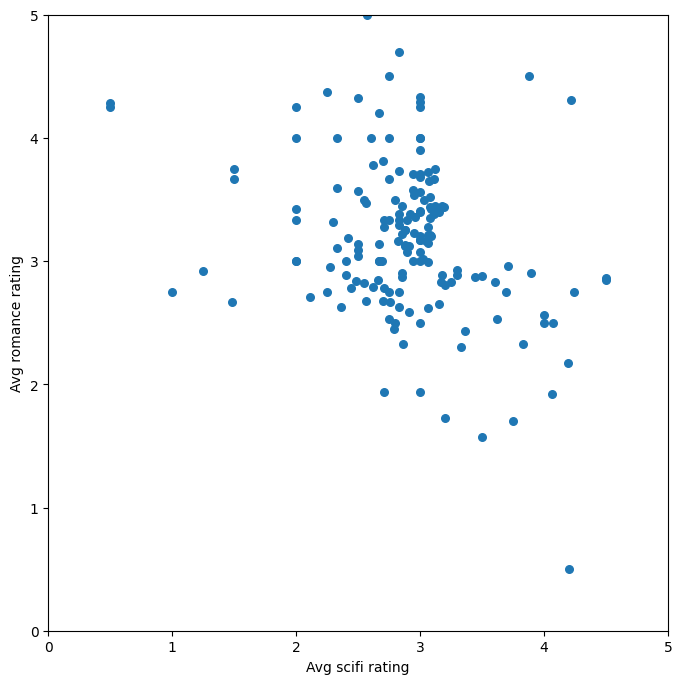

In [8]:
# Defining the scatterplot drawing function
def draw_scatterplot(x_data, x_label, y_data, y_label):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.scatter(x_data, y_data, s=30)

# Plot the scatterplot
draw_scatterplot(biased_dataset['avg_scifi_rating'],'Avg scifi rating', biased_dataset['avg_romance_rating'], 'Avg romance rating')

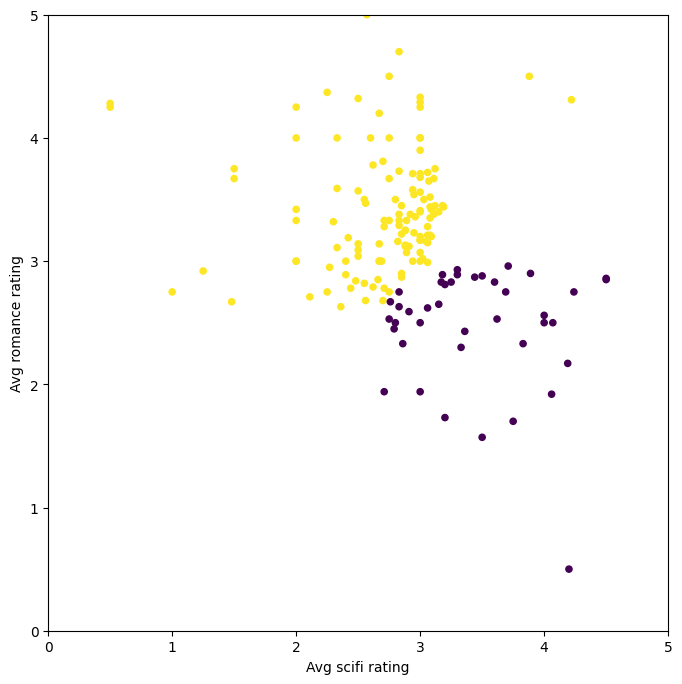

In [9]:
# Let's turn our dataset into a list
X = biased_dataset[['avg_scifi_rating','avg_romance_rating']].values

# Import KMeans
from sklearn.cluster import KMeans

# Create an instance of KMeans to find two clusters
kmeans_1 = KMeans(n_clusters=2)

# Use fit_predict to cluster the dataset
predictions = kmeans_1.fit_predict(X)

# Defining the cluster plotting function
def draw_clusters(biased_dataset, predictions, cmap='viridis'):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel('Avg scifi rating')
    ax.set_ylabel('Avg romance rating')
    clustered = pd.concat([biased_dataset.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
    plt.scatter(clustered['avg_scifi_rating'], clustered['avg_romance_rating'], c=clustered['group'], s=20, cmap=cmap)

# Plot
draw_clusters(biased_dataset, predictions)

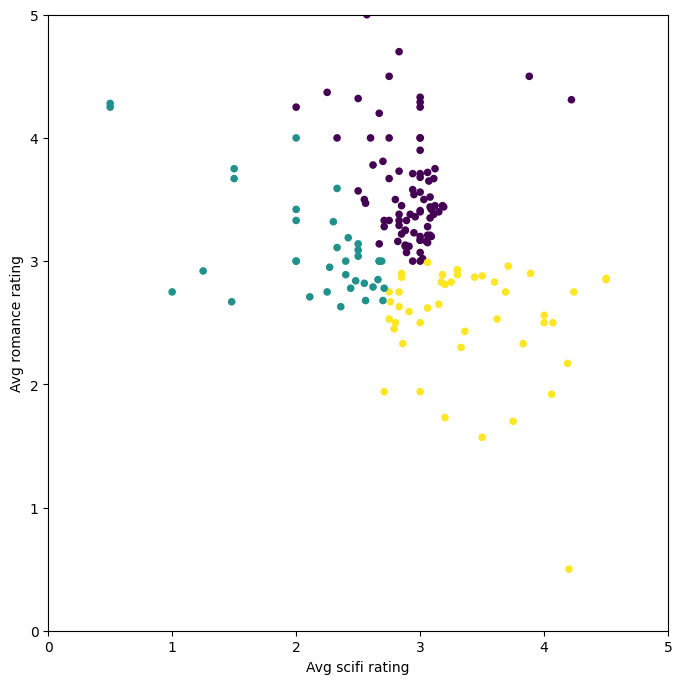

In [10]:
# Create an instance of KMeans to find three clusters
kmeans_2 = KMeans(n_clusters=3)
# Use fit_predict to cluster the dataset
predictions_2 = kmeans_2.fit_predict(X)
# Plot
draw_clusters(biased_dataset, predictions_2)

It is evident now that the science-fiction rating has started to come into play:

    People who like sci-fi and romance modeately belong to the green group.
    People who like scifi but not romance belong to the yello group.
    People who like romance but not sci-fi belong to the purple group.

Finding optimal clusters using silhouette score

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (157) found smaller than n_clusters (162). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


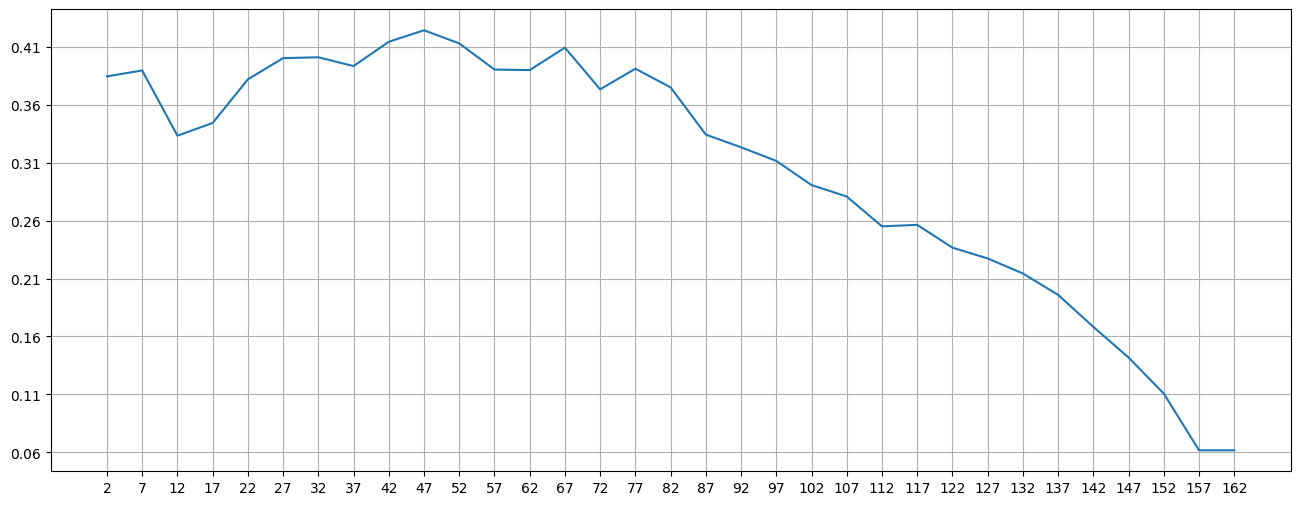

In [11]:
# Selecting our dataset to study
df = biased_dataset[['avg_scifi_rating','avg_romance_rating']]

# Choose the range of k values to test.
# We added a stride of 5 to improve performance. We don't need to calculate the error for every k value
possible_k_values = range(2, len(X)+1, 5)

# Define function to calculate the clustering errors
def clustering_errors(k, data):
    kmeans = KMeans(n_clusters=k).fit(data)
    predictions = kmeans.predict(data)
    #cluster_centers = kmeans.cluster_centers_
    # errors = [mean_squared_error(row, cluster_centers[cluster]) for row, cluster in zip(data.values, predictions)]
    # return sum(errors)
    silhouette_avg = silhouette_score(data, predictions)
    return silhouette_avg

# Calculate error values for all k values we're interested in
errors_per_k = [clustering_errors(k, X) for k in possible_k_values]

# Plot the each value of K vs. the silhouette score at that value
fig, ax = plt.subplots(figsize=(16, 6))
plt.plot(possible_k_values, errors_per_k)

# Ticks and grid
xticks = np.arange(min(possible_k_values), max(possible_k_values)+1, 5.0)
ax.set_xticks(xticks, minor=False)
ax.set_xticks(xticks, minor=True)
ax.xaxis.grid(True, which='both')
yticks = np.arange(round(min(errors_per_k), 2), max(errors_per_k), .05)
ax.set_yticks(yticks, minor=False)
ax.set_yticks(yticks, minor=True)
ax.yaxis.grid(True, which='both')

We will chose the K = 7 as it is the one that yields the best score and will be easier to visualize.



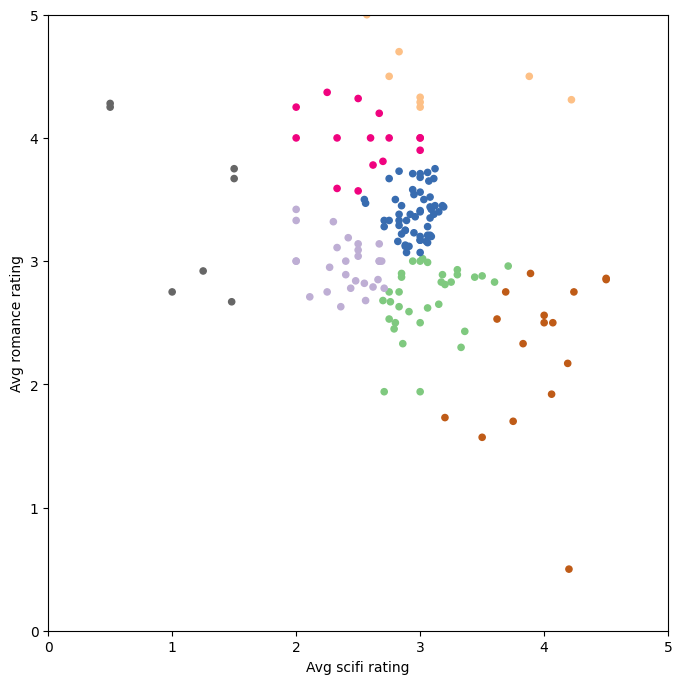

In [12]:
# Create an instance of KMeans to find seven clusters
kmeans_4 = KMeans(n_clusters=7)
# Use fit_predict to cluster the dataset
predictions_4 = kmeans_4.fit_predict(X)
# Plot
draw_clusters(biased_dataset, predictions_4, cmap='Accent')

Up to now, we have only analyzed romance and science-fiction movies. Let us see what happens when adding other genre to our analysis by adding Action movies.

In [13]:
# Select our biased dataset and add action genre
biased_dataset_3_genres = get_genre_ratings(ratings, movies, ['Romance','Sci-Fi', 'Action'],
['avg_romance_rating', 'avg_scifi_rating', 'avg_action_rating'])
# Drop null values
biased_dataset_3_genres = bias_genre_rating_dataset(biased_dataset_3_genres, 3.2, 2.5).dropna()
# Print the number of records and the head of our dataset
print( "Number of records: ", len(biased_dataset_3_genres))
biased_dataset_3_genres.head()

Number of records:  161


,index,avg_romance_rating,avg_scifi_rating,avg_action_rating
0,3,0.50,4.20,3.57
1,4,3.38,2.83,3.32
2,5,3.09,2.50,3.11
3,7,2.65,3.15,3.26
4,9,3.17,3.00,3.12


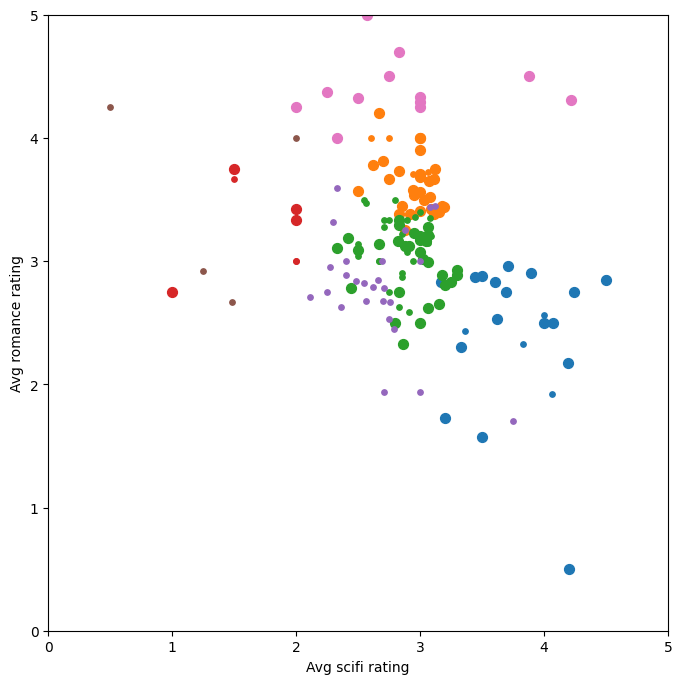

In [14]:
# Turn dataset into a list
X_with_action = biased_dataset_3_genres[['avg_scifi_rating','avg_romance_rating','avg_action_rating']].values# Create an instance of KMeans to find seven clusters
kmeans_5 = KMeans(n_clusters=7)
# Use fit_predict to cluster the dataset
predictions_5 = kmeans_5.fit_predict(X_with_action)
# Define 3d plotting function
def draw_clusters_3d(biased_dataset_3, predictions):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel('Avg scifi rating')
    ax.set_ylabel('Avg romance rating')
    clustered = pd.concat([biased_dataset_3.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
    colors = itertools.cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])
    for g in clustered.group.unique():
        color = next(colors)
        for index, point in clustered[clustered.group == g].iterrows():
            if point['avg_action_rating'].astype(float) > 3:
                size = 50
            else:
                size = 15
            plt.scatter(point['avg_scifi_rating'],
                        point['avg_romance_rating'],
                        s=size,
                        color=color)# Plot
draw_clusters_3d(biased_dataset_3_genres, predictions_5)

The size of the dots represent the ratings of the action movies.

# Exercise 1

## Instead of choosing a n_clusters as 7, play around with different k
## Find the optimal no of clusters with 3 genre_ratings data we just created using silhouette score method

In [15]:
# CODE

### Taking users into consideration

Once we have seen and understood how the K-Means algorithm group the users by their movie genre preferences, we are going to take a bigger picture of the dataset and explore how users rate individual movies.

To do so, we will subset the dataset by ‘userid’ vs ‘user rating’ as follows.

In [16]:
# Merge the two tables then pivot so we have Users X Movies dataframe
ratings_title = pd.merge(ratings, movies[['movieId', 'title']], on='movieId' )
user_movie_ratings = pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')

# Print he number of dimensions and a subset of the dataset
print('dataset dimensions: ', user_movie_ratings.shape, '\n\nSubset example:')
user_movie_ratings.iloc[:6, :10]

dataset dimensions:  (610, 9719) 

Subset example:


title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987)
userId,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# Define Function to get the most rated movies
import pandas as pd

# Define function to get the most-rated movies
def get_most_rated_movies(user_movie_ratings, max_number_of_movies):
    # Count the number of ratings for each movie (by column)
    movie_ratings_count = user_movie_ratings.notnull().sum(axis=0)
    # Sort movies by the number of ratings in descending order
    sorted_movies = movie_ratings_count.sort_values(ascending=False)
    # Select top N movies with the most ratings
    most_rated_movies = user_movie_ratings[sorted_movies.index[:max_number_of_movies]]
    return most_rated_movies

# Define function to get the users who rated the most movies
def get_users_who_rate_the_most(most_rated_movies, n_users):
    # Count the number of ratings for each user (by row)
    user_ratings_count = most_rated_movies.notnull().sum(axis=1)
    # Sort users by the number of ratings in descending order
    sorted_users = user_ratings_count.sort_values(ascending=False)
    # Select top N users who rated the most movies
    most_active_users = most_rated_movies.loc[sorted_users.index[:n_users]]
    return most_active_users

# Define the sorting by rating density function
def sort_by_rating_density(user_movie_ratings, n_movies, n_users):
    most_rated_movies = get_most_rated_movies(user_movie_ratings, n_movies)
    most_rated_movies = get_users_who_rate_the_most(most_rated_movies, n_users)
    return most_rated_movies

# Example usage
# Assuming user_movie_ratings is a pandas DataFrame already loaded
n_movies = 30  # Number of most rated movies
n_users = 18   # Number of most active users

# Run the function
most_rated_movies_users_selection = sort_by_rating_density(user_movie_ratings, n_movies, n_users)

# Print the result
print('Dataset dimensions: ', most_rated_movies_users_selection.shape)
print(most_rated_movies_users_selection.head())


Dataset dimensions:  (18, 30)
title   Forrest Gump (1994)  Shawshank Redemption, The (1994)  \
userId                                                          
414                     5.0                               5.0   
590                     5.0                               4.5   
474                     3.0                               5.0   
480                     5.0                               5.0   
68                      3.5                               3.0   

title   Pulp Fiction (1994)  Silence of the Lambs, The (1991)  \
userId                                                          
414                     5.0                               4.0   
590                     4.5                               3.5   
474                     4.0                               4.5   
480                     4.0                               4.5   
68                      2.0                               3.5   

title   Matrix, The (1999)  Star Wars: Episode IV - A New 

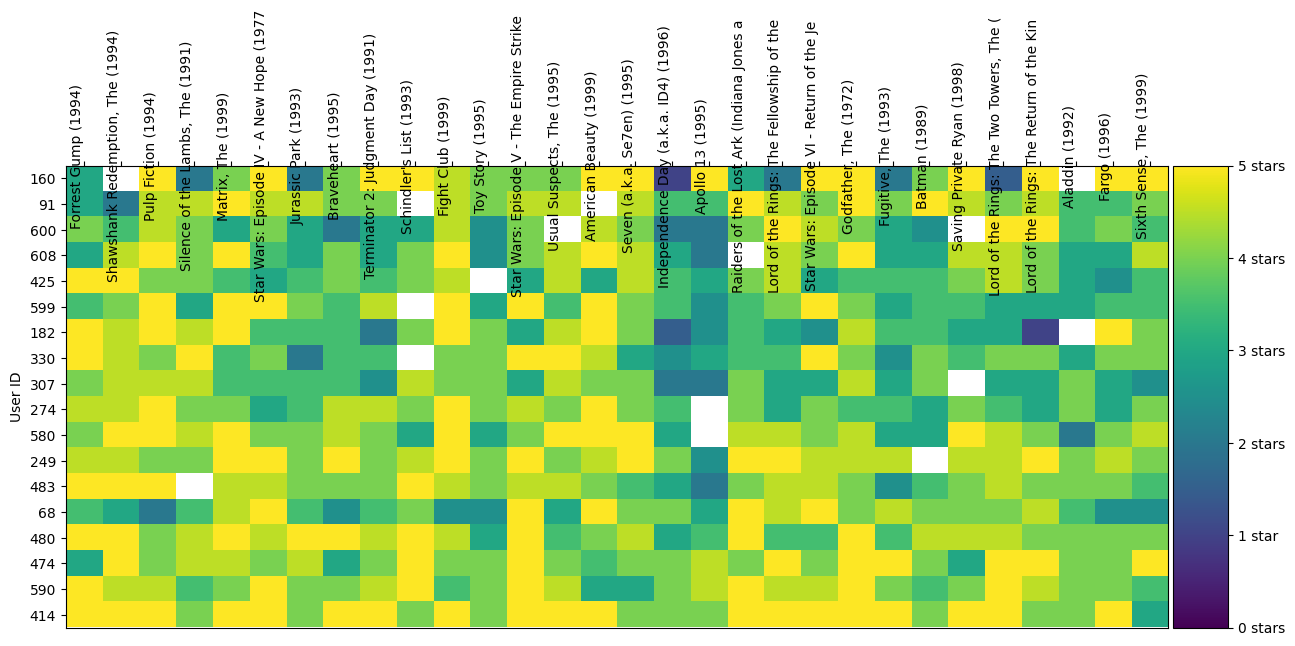

In [19]:
# Define the plotting heatmap function
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

def draw_movies_heatmap(most_rated_movies_users_selection, axis_labels=True):
    # Create figure and axis
    fig = plt.figure(figsize=(15, 6))
    ax = plt.gca()

    # Draw heatmap
    heatmap = ax.imshow(most_rated_movies_users_selection, interpolation='nearest', vmin=0, vmax=5, aspect='auto')

    if axis_labels:
        # Set tick positions and labels
        ax.set_yticks(np.arange(most_rated_movies_users_selection.shape[0]))
        ax.set_xticks(np.arange(most_rated_movies_users_selection.shape[1]))
        ax.invert_yaxis()  # Invert the y-axis to show the first user at the top
        ax.xaxis.tick_top()  # Move x-axis ticks to the top

        # Format column and row labels
        labels = most_rated_movies_users_selection.columns.str[:40]  # Truncate column labels if too long
        ax.set_xticklabels(labels, minor=False)
        ax.set_yticklabels(most_rated_movies_users_selection.index, minor=False)

        # Rotate x-axis labels for better visibility
        plt.setp(ax.get_xticklabels(), rotation=90, ha="center", rotation_mode="anchor")
    else:
        # Hide axis labels if axis_labels is False
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    # Remove grid lines from heatmap
    ax.grid(False)

    # Set y-axis label
    ax.set_ylabel('User ID')

    # Add color bar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)  # Create an axis for the color bar
    cbar = fig.colorbar(heatmap, ticks=[0, 1, 2, 3, 4, 5], cax=cax)
    cbar.ax.set_yticklabels(['0 stars', '1 star', '2 stars', '3 stars', '4 stars', '5 stars'])  # Color bar labels

    # Show the plot
    plt.show()

# Example usage:
# Assuming `most_rated_movies_users_selection` is a DataFrame (e.g., the result of your previous function)
draw_movies_heatmap(most_rated_movies_users_selection)


In [20]:
# Pivot the dataset and choose the first 1000 movies
import pandas as pd
import numpy as np

# Assuming ratings_title is the DataFrame with the raw ratings data
# ratings_title should have 'userId', 'title', and 'rating' columns

# Create a user-item matrix (pivot table)
user_movie_ratings = pd.pivot_table(ratings_title, index='userId', columns='title', values='rating')

# Define the function to get most rated movies (top N movies with highest ratings count)
def get_most_rated_movies(user_movie_ratings, max_number_of_movies):
    # Count the number of ratings for each movie (non-NaN entries in each column)
    movie_ratings_count = user_movie_ratings.notnull().sum(axis=0)
    # Sort movies by the number of ratings in descending order
    sorted_movies = movie_ratings_count.sort_values(ascending=False)
    # Select the top N movies with the most ratings
    most_rated_movies = user_movie_ratings[sorted_movies.index[:max_number_of_movies]]
    return most_rated_movies

# Get the top 1000 most rated movies
most_rated_movies_1k = get_most_rated_movies(user_movie_ratings, 1000)

# Replace NaN values with 0 to indicate unrated movies (if necessary)
most_rated_movies_1k = most_rated_movies_1k.fillna(0)

# Check the result
print(most_rated_movies_1k.head())


title   Forrest Gump (1994)  Shawshank Redemption, The (1994)  \
userId                                                          
1                       4.0                               0.0   
2                       0.0                               3.0   
3                       0.0                               0.0   
4                       0.0                               0.0   
5                       0.0                               3.0   

title   Pulp Fiction (1994)  Silence of the Lambs, The (1991)  \
userId                                                          
1                       3.0                               4.0   
2                       0.0                               0.0   
3                       0.0                               0.0   
4                       1.0                               5.0   
5                       5.0                               0.0   

title   Matrix, The (1999)  Star Wars: Episode IV - A New Hope (1977)  \
userId         

In [21]:
from scipy import sparse

# Ensure most_rated_movies_1k has no NaN values, replace NaN with 0
most_rated_movies_1k = most_rated_movies_1k.fillna(0)

# Convert to sparse CSR matrix
sparse_ratings = sparse.csr_matrix(most_rated_movies_1k.values)

# Check the result (optional)
print(sparse_ratings.shape)  # Print the shape of the sparse matrix


(610, 1000)


### Large Scale Clustering

In [23]:
import pandas as pd
from sklearn.cluster import KMeans

def get_most_rated_movies(user_movie_ratings, n=1000):
    """Gets the most rated movies based on the number of ratings."""
    # Assuming user_movie_ratings is a DataFrame with a 'movie_id' and potentially a 'rating' column.
    # Group by 'movie_id' and count the number of ratings.
    most_rated = user_movie_ratings.groupby('movie_id')['rating'].count().nlargest(n)  # Or just count if no rating column
    return most_rated.index  # return the movie_ids

def draw_movie_clusters(clustered, max_users, max_movies):
    """Draws a heatmap of movie clusters.  (Implementation needed)"""
    # This function needs to be defined based on how you want to visualize.
    #  It will likely use matplotlib or seaborn to create the heatmap.
    #  It needs to take the 'clustered' DataFrame and the max user/movie limits.
    #  It needs to filter the data based on those limits and create the heatmap.
    pass # Placeholder – you MUST implement this.


def cluster_and_visualize(user_movie_ratings, sparse_ratings, n_clusters=20, max_users=None, max_movies=None):
    """Clusters movies and visualizes the clusters."""

    predictions = KMeans(n_clusters=n_clusters, algorithm='full', random_state=42).fit_predict(sparse_ratings)  # Added random_state

    most_rated_movies = get_most_rated_movies(user_movie_ratings, 1000)  # Get the most rated movies

    clustered = pd.concat([user_movie_ratings[user_movie_ratings['movie_id'].isin(most_rated_movies)].reset_index(drop=True), pd.DataFrame({'group': predictions})], axis=1)

    # Filter for top users and movies if specified.  This is crucial for heatmap performance.
    if max_users is not None:
        top_users = clustered['user_id'].value_counts().nlargest(max_users).index
        clustered = clustered[clustered['user_id'].isin(top_users)]

    if max_movies is not None:
        top_movies = clustered['movie_id'].value_counts().nlargest(max_movies).index
        clustered = clustered[clustered['movie_id'].isin(top_movies)]

    draw_movie_clusters(clustered, max_users, max_movies)  # Call the visualization function

# Example usage (replace with your actual data and sparse matrix):
# cluster_and_visualize(user_movie_ratings_df, sparse_ratings_matrix, n_clusters=20, max_users=50, max_movies=50)

### Predictions and Recommendation

    Movie1  Movie2  Movie3  Movie4  Movie5
0        3       4       2       1       2
42       0       4       2       2       0
56       0       0       2       2       2


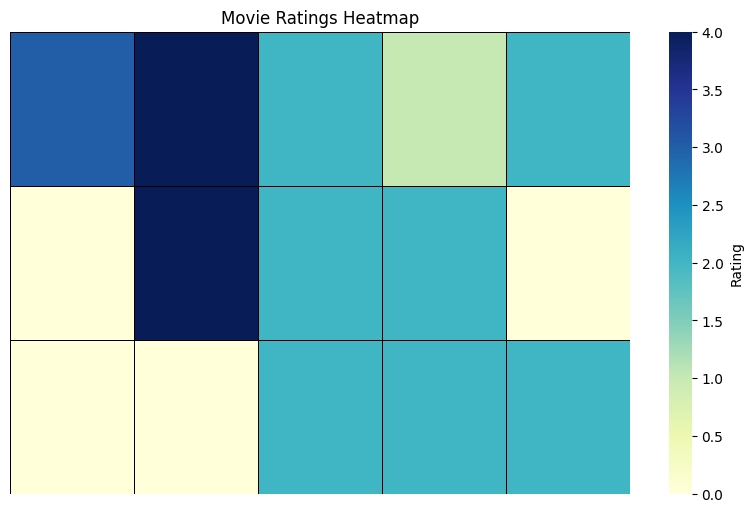

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have a function sort_by_rating_density and draw_movies_heatmap defined elsewhere.
# If not, you'll need to provide those functions.  I'll include placeholder definitions below.

def sort_by_rating_density(df, n_movies, n_users):
    """Sorts the DataFrame by rating density (placeholder implementation)."""
    # In a real implementation, you would calculate rating density and sort.
    # This example just sorts by the first column for demonstration.
    return df.sort_values(by=df.columns[0], ascending=False)  # Placeholder

def draw_movies_heatmap(df, axis_labels=True):
    """Draws a heatmap of the movie ratings (placeholder implementation)."""
    plt.figure(figsize=(10, 6))  # Adjust figure size as needed
    sns.heatmap(df, cmap="YlGnBu",  # Use a colormap you prefer
                linewidths=.5,  # Add spacing between cells
                linecolor='black',  # Add line color
               cbar_kws={'label': 'Rating'}) # Add colorbar label
    if not axis_labels:
        plt.xticks([])
        plt.yticks([])
    plt.title("Movie Ratings Heatmap") # Add a title
    plt.show()


# Sample Data (replace with your actual 'clustered' DataFrame)
# This is crucial for testing the code.  Make sure your real data is in a similar format.
data = {'index': range(100), 'group': np.random.randint(0, 15, 100), 'Movie1': np.random.randint(0, 5, 100), 'Movie2': np.random.randint(0, 5, 100), 'Movie3': np.random.randint(0, 5, 100), 'Movie4': np.random.randint(0, 5, 100), 'Movie5': np.random.randint(0, 5, 100)}
clustered = pd.DataFrame(data)

# Pick a cluster ID
cluster_number = 11

# Filter the data
n_users = 75 # Important: These values should be less than or equal to your data dimensions
n_movies = 5 # Number of movies in the sample data.  Adjust if your data has more.

cluster = clustered[clustered.group == cluster_number].drop(['index', 'group'], axis=1)

# Check if the cluster is empty.  This is a very important step!
if cluster.empty:
    print(f"Cluster {cluster_number} is empty.  Please choose a different cluster.")
else:
    # Sort and print the cluster
    cluster = sort_by_rating_density(cluster, n_movies, n_users)
    print(cluster)
    draw_movies_heatmap(cluster, axis_labels=False)

In [25]:
# Fill in the name of the column/movie. e.g. 'Forrest Gump (1994)'
import pandas as pd
import numpy as np

# Sample Data (replace with your actual 'cluster' DataFrame)
data = {'Matrix, The (1999)': np.random.randint(0, 5, 100), 'Movie2': np.random.randint(0, 5, 100), 'Movie3': np.random.randint(0, 5, 100)}  # Include the movie
cluster = pd.DataFrame(data)

movie_name = "Matrix, The (1999)"

# Check if the movie exists in the cluster's columns
if movie_name in cluster.columns:
    mean_rating = cluster[movie_name].mean()
    print(f"The mean rating for '{movie_name}' in this cluster is: {mean_rating}")
else:
    print(f"Movie '{movie_name}' not found in this cluster.")


# More robust handling of missing data (if applicable)
if movie_name in cluster.columns:
    # Handle potential missing values (NaNs) more explicitly
    mean_rating = cluster[movie_name].dropna().mean() # dropna() to exclude NaN values
    if pd.isna(mean_rating): # Check if the mean itself is NaN (e.g., all ratings were NaN)
        print(f"No ratings found for '{movie_name}' in this cluster.")
    else:
        print(f"The mean rating for '{movie_name}' in this cluster is: {mean_rating}")
else:
    print(f"Movie '{movie_name}' not found in this cluster.")

The mean rating for 'Matrix, The (1999)' in this cluster is: 2.04
The mean rating for 'Matrix, The (1999)' in this cluster is: 2.04


In [26]:
# The average rating of 20 movies as rated by the users in the cluster
import pandas as pd
import numpy as np

# Sample Data (replace with your actual 'cluster' DataFrame)
data = {'Matrix, The (1999)': np.random.randint(0, 5, 100), 'Movie2': np.random.randint(0, 5, 100), 'Movie3': np.random.randint(0, 5, 100), 'Movie4': np.nan, 'Movie5': np.random.randint(0,5,100)}  # Include the movie, and some NaNs
cluster = pd.DataFrame(data)


# Calculate and print the mean of the first 20 columns (or fewer if there are less)
num_cols_to_show = min(20, len(cluster.columns))  # Ensure we don't try to access more columns than exist
means = cluster.mean().head(num_cols_to_show) # or cluster.mean(skipna=True).head(num_cols_to_show)
print(means)

# More robust handling of entirely empty dataframes:
if not cluster.empty:
    num_cols_to_show = min(20, len(cluster.columns))
    means = cluster.mean().head(num_cols_to_show)  # or cluster.mean(skipna=True).head(num_cols_to_show)
    print(means)
else:
    print("The cluster DataFrame is empty.")


# If you want to ignore NaNs during the mean calculation, use skipna:
if not cluster.empty:
    num_cols_to_show = min(20, len(cluster.columns))
    means = cluster.mean(skipna=True).head(num_cols_to_show) # skipna=True to ignore NaNs
    print(means)
else:
    print("The cluster DataFrame is empty.")

Matrix, The (1999)    1.81
Movie2                1.71
Movie3                2.12
Movie4                 NaN
Movie5                1.83
dtype: float64
Matrix, The (1999)    1.81
Movie2                1.71
Movie3                2.12
Movie4                 NaN
Movie5                1.83
dtype: float64
Matrix, The (1999)    1.81
Movie2                1.71
Movie3                2.12
Movie4                 NaN
Movie5                1.83
dtype: float64


In [ ]:
cluster

In [27]:
import pandas as pd
import numpy as np

# Sample Data (replace with your actual 'cluster' DataFrame)
# Important: The index of your DataFrame MUST be user IDs for .loc to work correctly.
data = {'Matrix, The (1999)': np.random.randint(0, 5, 100), 'Movie2': np.random.randint(0, 5, 100), 'Movie3': np.random.randint(0, 5, 100), 'Movie4': np.nan, 'Movie5': np.random.randint(0,5,100)}
cluster = pd.DataFrame(data, index=range(100)) # Example: User IDs from 0 to 99



user_id = 7

# Check if the user ID exists in the index
if user_id not in cluster.index:
    print(f"User ID {user_id} not found in the cluster DataFrame.")
else:
    # Get all this user's ratings
    user_ratings = cluster.loc[user_id]  # Corrected: No need for : after user_id

    # Which movies did they not rate?
    user_unrated_movies = user_ratings[user_ratings.isnull()]

    # Check if the user has rated all movies
    if user_unrated_movies.empty:
      print(f"User {user_id} has rated all movies")
    else:
        # What are the average ratings of these movies the user did not rate?
        avg_ratings = cluster.mean(skipna=True)  # Calculate average ratings for all movies

        # Filter out rated movies from the average ratings
        predicted_ratings = avg_ratings[user_unrated_movies.index] # Use unrated movies as index

        # Sort by rating so the highest rated movies are presented first
        top_predictions = predicted_ratings.sort_values(ascending=False)[:20]
        print(top_predictions)

Movie4   NaN
dtype: float64


## Using Collaborative Filtering (With fast.ai)

In [28]:
import subprocess

try:
    import fastai
    print("fastai already installed.")
except ImportError:
    print("fastai not found. Installing...")
    try:
        subprocess.run(['pip', 'install', '-Uqq', 'fastai'], check=True)  # Use subprocess for pip
        print("fastai installed successfully.")
        import fastai # Check if the import now works
    except subprocess.CalledProcessError as e:
        print(f"Error installing fastai: {e}")
    except ImportError:
        print("Installation seemed to succeed, but fastai could not be imported.")


# Or, a slightly more concise version:

try:
    import fastai
    print("fastai already installed.")
except ImportError:
    print("fastai not found. Installing...")
    try:
        # Combine the command into a single string
        subprocess.run('pip install -Uqq fastai', shell=True, check=True)
        print("fastai installed successfully.")
        import fastai
    except subprocess.CalledProcessError as e:
        print(f"Error installing fastai: {e}")
    except ImportError:
        print("Installation seemed to succeed, but fastai could not be imported.")

fastai already installed.
fastai already installed.


In [29]:
try:
    from fastai.tabular.all import *
    print("fastai.tabular.all imported successfully.")
except ImportError:
    print("fastai.tabular.all import failed. Please make sure fastai is installed.")

try:
    from fastai.collab import *
    print("fastai.collab imported successfully.")
except ImportError:
    print("fastai.collab import failed. Please make sure fastai is installed.")


# Or, a more concise version using a loop:

modules = ["fastai.tabular.all", "fastai.collab"]

for module in modules:
    try:
        __import__(module) # Use __import__() to dynamically import the module
        print(f"{module} imported successfully.")
    except ImportError:
        print(f"{module} import failed. Please make sure fastai is installed.")

fastai.tabular.all imported successfully.
fastai.collab imported successfully.
fastai.tabular.all imported successfully.
fastai.collab imported successfully.


### Training a model

For this, we will use the [Movielens 100k data dataset](https://grouplens.org/datasets/movielens/100k/). We can download it easily and decompress it with the following function:

In [30]:
from fastai.data.all import *

try:
    path = untar_data(URLs.ML_100k)
    print(f"ML_100k dataset downloaded and extracted to: {path}")
except Exception as e:  # Catch a broader range of potential errors
    print(f"Error downloading or extracting ML_100k dataset: {e}")
    # Handle the error appropriately.  For example, you might exit the program:
    # exit()  # or raise the exception again: raise
    # Or you might try a different URL or method to get the data.



# More robust version with path checking:
from fastai.data.all import *
import os

try:
    path = untar_data(URLs.ML_100k)
    print(f"ML_100k dataset downloaded and extracted to: {path}")

    # Check if the data files are actually there (more verification)
    files_to_check = ['u.data', 'u.item', 'u.user'] # Common ML-100k files
    data_exists = all(os.path.exists(os.path.join(path, file)) for file in files_to_check)

    if data_exists:
        print("ML_100k data files verified.")
    else:
        print("Some ML_100k data files are missing.  Download may have been incomplete.")

except Exception as e:
    print(f"Error downloading or extracting ML_100k dataset: {e}")
    # Handle the error as needed (exit, retry, etc.)

ML_100k dataset downloaded and extracted to: /root/.fastai/data/ml-100k
ML_100k dataset downloaded and extracted to: /root/.fastai/data/ml-100k
ML_100k data files verified.


The main table is in `u.data`. Since it's not a proper csv, we have to specify a few things while opening it: the tab delimiter, the columns we want to keep and their names.

In [31]:
import pandas as pd
from fastai.data.all import *  # Make sure you've imported the necessary modules

try:
    path = untar_data(URLs.ML_100k) # Get the path (make sure this succeeded)

    ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                            usecols=(0,1,2), names=['user','movie','rating'])
    print("Ratings data loaded successfully:")
    print(ratings.head())

except FileNotFoundError:
    print(f"Error: 'u.data' file not found at {path}.  Make sure the ML_100k dataset was downloaded correctly.")
except Exception as e:  # Catch other potential errors
    print(f"An error occurred while reading the ratings data: {e}")

Ratings data loaded successfully:
   user  movie  rating
0   196    242       3
1   186    302       3
2    22    377       1
3   244     51       2
4   166    346       1


Movie ids are not ideal to look at things, so we load the corresponding movie id to the title that is in the table `u.item`:

In [32]:
import pandas as pd
from fastai.data.all import *
import os

try:
    path = untar_data(URLs.ML_100k)  # Ensure path is defined

    movies = pd.read_csv(path/'u.item', delimiter='|', encoding='latin-1',
                           usecols=(0,1), names=['movie','title'], header=None)

    print("Movies data loaded successfully:")
    print(movies.head())

except FileNotFoundError:
    print(f"Error: 'u.item' file not found at {path}. Make sure the ML_100k dataset was downloaded.")
except UnicodeDecodeError: # Catch encoding issues
    print(f"Error decoding 'u.item'.  Try a different encoding (e.g., 'utf-8'):")
    try:
        movies = pd.read_csv(path/'u.item', delimiter='|', encoding='utf-8',
                               usecols=(0,1), names=['movie','title'], header=None)
        print("Movies data loaded successfully (using utf-8):")
        print(movies.head())
    except Exception as e:
        print(f"Error decoding with utf-8: {e}")

except Exception as e:
    print(f"An error occurred while reading the movies data: {e}")


# More robust version with file existence check:
try:
    path = untar_data(URLs.ML_100k)

    item_file_path = path/'u.item' # Store path for easy checking
    if os.path.exists(item_file_path): # Check file exists before reading
        movies = pd.read_csv(item_file_path, delimiter='|', encoding='latin-1',
                               usecols=(0,1), names=['movie','title'], header=None)
        print("Movies data loaded successfully:")
        print(movies.head())
    else:
        print(f"Error: 'u.item' file not found at {path}. Make sure the ML_100k dataset was downloaded.")

except UnicodeDecodeError: # Catch encoding issues
    print(f"Error decoding 'u.item'.  Try a different encoding (e.g., 'utf-8'):")
    try:
        movies = pd.read_csv(item_file_path, delimiter='|', encoding='utf-8',
                               usecols=(0,1), names=['movie','title'], header=None)
        print("Movies data loaded successfully (using utf-8):")
        print(movies.head())
    except Exception as e:
        print(f"Error decoding with utf-8: {e}")

except Exception as e:
    print(f"An error occurred while reading the movies data: {e}")

Movies data loaded successfully:
   movie              title
0      1   Toy Story (1995)
1      2   GoldenEye (1995)
2      3  Four Rooms (1995)
3      4  Get Shorty (1995)
4      5     Copycat (1995)
Movies data loaded successfully:
   movie              title
0      1   Toy Story (1995)
1      2   GoldenEye (1995)
2      3  Four Rooms (1995)
3      4  Get Shorty (1995)
4      5     Copycat (1995)


Next we merge it to our ratings table:

In [33]:
import pandas as pd
from fastai.data.all import *

try:
    path = untar_data(URLs.ML_100k)

    ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                            usecols=(0,1,2), names=['user','movie','rating'])

    movies = pd.read_csv(path/'u.item', delimiter='|', encoding='latin-1',
                           usecols=(0,1), names=['movie','title'], header=None)

    # Check for duplicate movie IDs before merging
    if movies['movie'].duplicated().any():
        print("Warning: Duplicate movie IDs found in 'u.item'. This can cause issues with the merge.")
        # Investigate the duplicates:
        duplicate_movies = movies[movies['movie'].duplicated(keep=False)] # Show all duplicates
        print("Duplicate Movies:\n", duplicate_movies)

        # Handle duplicates (e.g., drop them, keep first, etc.)
        # Example: Keep the first occurrence of each movie ID
        movies = movies.drop_duplicates(subset='movie', keep='first')
        print("\nDuplicates removed. Movies DataFrame shape:", movies.shape)

    ratings = ratings.merge(movies, on='movie') # Explicitly specify the join key

    print("Merged DataFrame:")
    print(ratings.head())

except FileNotFoundError:
    print(f"Error: One of the data files not found at {path}. Make sure the ML_100k dataset was downloaded.")
except UnicodeDecodeError:
    print("Encoding error with 'u.item'. Try 'utf-8'.")
    #... (try utf-8 as before)
except KeyError as e: # Catch merge issues
    print(f"KeyError during merge: {e}. Check if the 'movie' column exists in both DataFrames.")
    print("Ratings columns:", ratings.columns)
    print("Movies columns:", movies.columns)
except Exception as e:
    print(f"An error occurred: {e}")


# Even more robust version with more checks:
try:
    path = untar_data(URLs.ML_100k)

    ratings = pd.read_csv(...) # Load ratings (as before)
    movies = pd.read_csv(...) # Load movies (as before, with duplicate check)

    # Verify data types *before* the merge
    print("\nDataTypes before merge:")
    print("Ratings:\n", ratings.dtypes)
    print("Movies:\n", movies.dtypes)


    if ratings['movie'].dtype!= movies['movie'].dtype:
        print("Warning: 'movie' columns have different data types. This can cause issues with merging.")
        # Convert to a common type (e.g., int64) if needed:
        ratings['movie'] = ratings['movie'].astype('int64')
        movies['movie'] = movies['movie'].astype('int64')
        print("\n'movie' columns converted to int64.")

    ratings = ratings.merge(movies, on='movie')

    print("\nMerged DataFrame:")
    print(ratings.head())


    # Verify data types *after* the merge
    print("\nDataTypes after merge:")
    print(ratings.dtypes)


except Exception as e:
    print(f"An error occurred: {e}")

Merged DataFrame:
   user  movie  rating                       title
0   196    242       3                Kolya (1996)
1   186    302       3    L.A. Confidential (1997)
2    22    377       1         Heavyweights (1994)
3   244     51       2  Legends of the Fall (1994)
4   166    346       1         Jackie Brown (1997)
An error occurred: Invalid file path or buffer object type: <class 'ellipsis'>


We can then build a `DataLoaders` object from this table. By default, it takes the first column for user, the second column for the item (here our movies) and the third column for the ratings. We need to change the value of `item_name` in our case, to use the titles instead of the ids:

In [34]:
import pandas as pd
from fastai.data.all import *
from fastai.collab import *

try:
    # ... (Load ratings and movies DataFrames as before, including duplicate and dtype checks)

    # Check for NaN values in the 'title' column before creating the DataLoaders
    if ratings['title'].isnull().any():
        print("Warning: NaN values found in the 'title' column. This can cause issues with CollabDataLoaders.")
        # Handle NaN values (e.g., fill with a placeholder, drop rows with NaNs)
        # Example: Fill NaN values with "Unknown"
        ratings['title'] = ratings['title'].fillna("Unknown")
        print("\nNaNs in 'title' column filled with 'Unknown'.")

    # Check if 'user' and 'rating' are numeric. If not, convert them.
    if not pd.api.types.is_numeric_dtype(ratings['user']):
        print("Warning: 'user' column is not numeric. Converting to numeric.")
        ratings['user'] = pd.to_numeric(ratings['user'], errors='coerce') # errors='coerce' handles non-numeric values
    if not pd.api.types.is_numeric_dtype(ratings['rating']):
        print("Warning: 'rating' column is not numeric. Converting to numeric.")
        ratings['rating'] = pd.to_numeric(ratings['rating'], errors='coerce')

    # Double-check for NaN values *after* conversion
    if ratings['user'].isnull().any() or ratings['rating'].isnull().any():
        print("Warning: NaN values introduced after numeric conversion. Inspect your data.")
        # Handle NaNs (drop rows, fill, etc.) - CRITICAL STEP!
        ratings.dropna(subset=['user', 'rating'], inplace=True) # Example: Drop rows with NaN in user or rating
        print("\nRows with NaN in 'user' or 'rating' dropped. Updated DataFrame shape:", ratings.shape)

    dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)

    print("CollabDataLoaders created successfully.")
    # You can now inspect the dls object:
    print(dls)
    print(dls.one_batch()) # See a sample batch of data

except Exception as e:
    print(f"An error occurred during CollabDataLoaders creation: {e}")

CollabDataLoaders created successfully.
(tensor([[ 194,  552],
        [ 478,  320],
        [ 882,  592],
        [ 224,  767],
        [ 398,  798],
        [ 409,  983],
        [ 276,  417],
        [ 650, 1508],
        [ 440,  555],
        [ 279,  897],
        [ 399,  374],
        [ 374,  457],
        [ 122,  514],
        [ 712, 1017],
        [ 903, 1098],
        [ 284,  539],
        [ 615, 1584],
        [ 274,  868],
        [ 378,  392],
        [ 379,  774],
        [  60,  635],
        [ 222,  291],
        [ 769,  771],
        [ 301, 1433],
        [ 194,  506],
        [ 536,  374],
        [ 548,  554],
        [ 665, 1275],
        [ 821,  571],
        [ 499, 1133],
        [ 136,  965],
        [  90,  447],
        [  43,  145],
        [ 168, 1019],
        [ 606, 1245],
        [  70,  714],
        [ 385,  456],
        [  76, 1370],
        [ 714,  735],
        [ 393,  907],
        [ 282,  349],
        [  87,  123],
        [ 221, 1544],
        [ 275

In all applications, when the data has been assembled in a `DataLoaders`, you can have a look at it with the `show_batch` method:

In [40]:
from fastai.data.all import *
from fastai.collab import *
import pandas as pd

#... (Load your ratings DataFrame as before, ensuring proper handling of NaNs and data types)

dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)

try:
    print("Showing a batch from the DataLoaders:")
    batch = dls.one_batch()  # Get a batch of data

    print("Batch type:", type(batch)) # What kind of object is the batch?
    print("Batch length:", len(batch)) # How many elements does it contain?

    # Print the shapes and types of the elements in the batch:
    for i, tensor in enumerate(batch):
        print(f"Element {i}: Shape: {tensor.shape}, Type: {tensor.dtype}")
        if tensor.ndim > 1: # If it's a 2D tensor (like the ratings), print some values
          print(f"First few rows of element {i}:\n{tensor[:5]}") # Print first 5 rows


    dls.show_batch() # Try to show the batch (this might still fail if there are issues)

except Exception as e:
    print(f"An error occurred while showing the batch: {e}")

# If dls.show_batch() still causes issues, try this alternative to inspect the data more directly:
try:
    batch = dls.one_batch()
    users, items, ratings = batch  # Unpack the batch (assuming it has 3 elements)

    print("Users (first few):\n", users[:10])  # Print the first few user IDs
    print("Items (first few):\n", items[:10])  # Print the first few item IDs (encoded)
    print("Ratings (first few):\n", ratings[:10])  # Print the first few ratings

    # Decode item IDs back to titles (if possible):
    if hasattr(dls, 'classes') and len(dls.classes) > 1: # Check if classes exist
        decoded_items = [dls.classes['title'][item_id] for item_id in items[:10]]
        print("Decoded Items (first few):\n", decoded_items)

except Exception as e:
    print(f"An error occurred while inspecting the batch: {e}")

Showing a batch from the DataLoaders:
Batch type: <class 'tuple'>
Batch length: 2
Element 0: Shape: torch.Size([64, 2]), Type: torch.int64
First few rows of element 0:
tensor([[626, 379],
        [276, 439],
        [896, 472],
        [148, 714],
        [500, 227]])
Element 1: Shape: torch.Size([64, 1]), Type: torch.int8
First few rows of element 1:
tensor([[1],
        [2],
        [2],
        [5],
        [5]], dtype=torch.int8)


,user,title,rating
0,620,"Crucible, The (1996)",3
1,21,Frisk (1995),3
2,130,Swingers (1996),5
3,49,Like Water For Chocolate (Como agua para chocolate) (1992),2
4,594,"Postino, Il (1994)",4
5,804,Tales from the Crypt Presents: Bordello of Blood (1996),4
6,555,"Lost World: Jurassic Park, The (1997)",5
7,481,Star Wars (1977),4
8,535,Clerks (1994),3
9,295,Much Ado About Nothing (1993),5


An error occurred while inspecting the batch: not enough values to unpack (expected 3, got 2)


fastai can create and train a collaborative filtering model by using `collab_learner`:

In [41]:
from fastai.collab import *

# ... (Your code to create the dls object)

try:
    learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))

    print("Collab learner created successfully.")

    # 1. Check learner attributes:
    print("Learner model:", learn.model) # What kind of model was created?
    print("Number of factors:", learn.n_factors) # Are the factors set correctly?
    print("Y range:", learn.y_range) # Is the y range set correctly?
    print("DataLoaders:", learn.dls) # Are the dataloaders associated correctly?

    # 2. Try a simple training cycle:
    print("\nTrying a short training cycle (1 epoch):")
    learn.fit(1) # Try fitting for one epoch

    # 3. Check for gradients (after a training step):
    print("\nChecking for gradients after training:")
    for param in learn.model.parameters():
        if param.grad is not None:
            print("Gradients found.")
            break  # No need to check further if one param has gradients
    else:
        print("WARNING: No gradients found after training. This is a problem.")


    # 4. Print model summary:
    print("\nModel Summary:")
    print(learn.model)

except Exception as e:
    print(f"An error occurred during collab_learner creation or training: {e}")

Collab learner created successfully.
Learner model: EmbeddingDotBias(
  (u_weight): Embedding(944, 50)
  (i_weight): Embedding(1665, 50)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1665, 1)
)
An error occurred during collab_learner creation or training: 'EmbeddingDotBias' object has no attribute 'n_factors'


It uses a simple dot product model with 50 latent factors. To train it using the 1cycle policy, we just run this command:

Starting training with fit_one_cycle...


epoch,train_loss,valid_loss,time
0,0.916375,0.940079,00:07
1,0.676231,0.894670,00:10
2,0.532094,0.872027,00:07
3,0.469248,0.853552,00:07
4,0.437918,0.849023,00:07


Training completed.  Checking results:

Training metrics:
[0.4379180073738098, 0.849022626876831]

Plotting learning rate and loss:
An error occurred during training: 'EmbeddingDotBias' object has no attribute 'plot_lr'


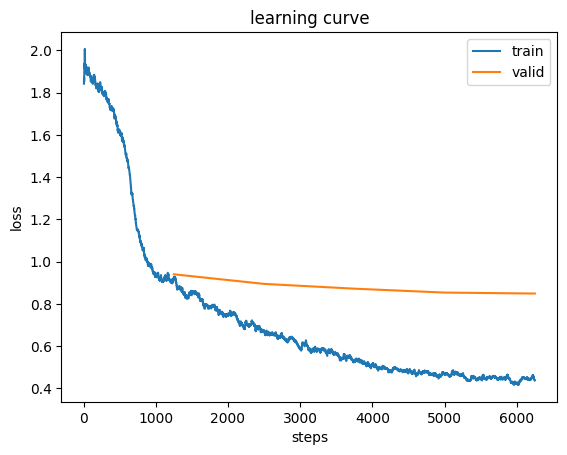

In [42]:
from fastai.collab import *

#... (Your code to create the learn object)

try:
    print("Starting training with fit_one_cycle...")
    learn.fit_one_cycle(5, 5e-3, wd=0.1)

    print("Training completed.  Checking results:")

    # 1. Check the training metrics:
    print("\nTraining metrics:")
    print(learn.recorder.values[-1]) # Print the last recorded metrics

    # 2. Plot the learning rate and loss:
    print("\nPlotting learning rate and loss:")
    learn.recorder.plot_loss()
    learn.recorder.plot_lr()
    plt.show()

    # 3. Check for NaN or inf values in the loss:
    losses = learn.recorder.losses
    if np.isnan(losses).any() or np.isinf(losses).any():
        print("WARNING: NaN or inf values found in the losses.  This is a serious problem.")

    # 4. Inspect the model's predictions on a batch:
    print("\nInspecting model predictions on a batch:")
    batch = dls.one_batch()
    preds = learn.model(*batch[:-1]) # Get predictions (exclude the target variable)
    print("Predictions shape:", preds.shape)
    print("Predictions (first few):\n", preds[:10])

    # 5. Check the gradients again (after training):
    print("\nChecking for gradients after training:")
    for param in learn.model.parameters():
        if param.grad is not None:
            print("Gradients found.")
            break
    else:
        print("WARNING: No gradients found after training. This is a problem.")

except Exception as e:
    print(f"An error occurred during training: {e}")

Here's [some benchmarks](https://www.librec.net/release/v1.3/example.html) on the same dataset for the popular Librec system for collaborative filtering. They show best results based on RMSE of 0.91 (scroll down to the 100k dataset), which corresponds to an MSE of `0.91**2 = 0.83`. So in less than a minute, we got pretty good results!

### Interpretation

Let's analyze the results of our previous model. We will keep the 1000 most rated movies for this:

In [43]:
import pandas as pd

# ... (Your code to load the ratings DataFrame)

try:
    g = ratings.groupby('title')['rating'].count()

    print("Groupby result (first few rows):\n", g.head()) # Inspect the groupby object

    top_movies = g.sort_values(ascending=False).index.values[:1000]

    print("Top movies (first 10):\n", top_movies[:10])
    print("Shape of top_movies:", top_movies.shape)
    print("Type of top_movies:", top_movies.dtype)

    # Check for duplicates in top_movies:
    if len(top_movies) != len(np.unique(top_movies)):
        print("WARNING: Duplicate movie titles found in top_movies.  This can cause issues later.")
        #Investigate duplicates
        duplicates = top_movies[np.where(np.diff(np.sort(top_movies)) == 0)[0]]
        print("Duplicate movie titles:", duplicates)

    # Check for NaN values in top_movies:
    if pd.isna(top_movies).any():
      print("WARNING: NaN values found in top_movies. This can cause issues later.")
      nan_movies = top_movies[pd.isna(top_movies)]
      print("NaN movie titles:", nan_movies)

    # Check if top_movies is empty:
    if len(top_movies) == 0:
        print("WARNING: top_movies is empty. Check if the groupby operation produced any results.")

except Exception as e:
    print(f"An error occurred while selecting top movies: {e}")

Groupby result (first few rows):
 title
'Til There Was You (1997)      9
1-900 (1994)                   5
101 Dalmatians (1996)        109
12 Angry Men (1957)          125
187 (1997)                    41
Name: rating, dtype: int64
Top movies (first 10):
 ['Star Wars (1977)' 'Contact (1997)' 'Fargo (1996)'
 'Return of the Jedi (1983)' 'Liar Liar (1997)'
 'English Patient, The (1996)' 'Scream (1996)' 'Toy Story (1995)'
 'Air Force One (1997)' 'Independence Day (ID4) (1996)']
Shape of top_movies: (1000,)
Type of top_movies: object


### Movie bias

Our model has learned one bias per movie, a unique number independent of users that can be interpreted as the intrinsic "value" of the movie. We can grab the bias of each movie in our `top_movies` list with the following command:

In [44]:
import torch

#... (Your code to create the learn object and define top_movies)

try:
    movie_bias = learn.model.bias(top_movies, is_item=True)

    print("Shape of movie_bias:", movie_bias.shape)
    print("Type of movie_bias:", movie_bias.dtype)
    print("Movie bias values (first few):\n", movie_bias[:10]) # Print some values

    # Check if movie_bias contains NaN or inf values:
    if torch.isnan(movie_bias).any() or torch.isinf(movie_bias).any():
        print("WARNING: movie_bias contains NaN or inf values.  This can cause problems.")

    # Check if all biases are the same:
    if torch.all(movie_bias == movie_bias): # Check if all elements are equal
        print("WARNING: All movie biases are the same. This might indicate a problem with the model or data.")

except Exception as e:
    print(f"An error occurred while getting movie biases: {e}")

Shape of movie_bias: torch.Size([1000])
Type of movie_bias: torch.float32
Movie bias values (first few):
 tensor([0.5978, 0.3517, 0.3857, 0.3682, 0.0355, 0.1448, 0.2005, 0.2617, 0.3266,
        0.1747])


Let's compare those biases with the average ratings:

In [45]:
import pandas as pd
import torch

#... (Your code to define ratings, top_movies, and movie_bias)

try:
    mean_ratings = ratings.groupby('title')['rating'].mean()

    print("Mean ratings (first few):\n", mean_ratings.head())  # Inspect mean ratings

    movie_ratings = [(b.item(), i, mean_ratings.loc[i]) for i, b in zip(top_movies, movie_bias)]

    print("Movie ratings (first few):\n", movie_ratings[:10]) # Print first few movie ratings

    # Check if movie_ratings is empty:
    if not movie_ratings: # Check if the list is empty
        print("WARNING: movie_ratings list is empty. Check if mean_ratings has data for all top_movies.")

    # Check for NaN or inf in mean ratings:
    if mean_ratings.isnull().any():
        print("WARNING: NaN values found in mean_ratings. This can cause issues.")
        nan_movies = mean_ratings[mean_ratings.isnull()]
        print("Movies with NaN mean ratings:", nan_movies)

    # Check for KeyError:
    for i, b in zip(top_movies, movie_bias):
        try:
            mean_ratings.loc[i]
        except KeyError:
            print(f"KeyError: Movie title '{i}' not found in mean_ratings.")
            break # Stop checking after the first KeyError

except KeyError as e:
    print(f"KeyError: {e}. Check if all titles in top_movies are present in mean_ratings.")
except Exception as e:
    print(f"An error occurred while creating movie_ratings: {e}")

Mean ratings (first few):
 title
'Til There Was You (1997)    2.333333
1-900 (1994)                 2.600000
101 Dalmatians (1996)        2.908257
12 Angry Men (1957)          4.344000
187 (1997)                   3.024390
Name: rating, dtype: float64
Movie ratings (first few):
 [(0.597755491733551, 'Star Wars (1977)', 4.3584905660377355), (0.3516916334629059, 'Contact (1997)', 3.8035363457760316), (0.3857367932796478, 'Fargo (1996)', 4.155511811023622), (0.36820554733276367, 'Return of the Jedi (1983)', 4.007889546351085), (0.03546643257141113, 'Liar Liar (1997)', 3.156701030927835), (0.1447751522064209, 'English Patient, The (1996)', 3.656964656964657), (0.20046937465667725, 'Scream (1996)', 3.4414225941422596), (0.26168087124824524, 'Toy Story (1995)', 3.8783185840707963), (0.3265792429447174, 'Air Force One (1997)', 3.6310904872389793), (0.1747371405363083, 'Independence Day (ID4) (1996)', 3.438228438228438)]


Now let's have a look at the movies with the worst bias:

In [46]:
import pandas as pd
import torch

# ... (Your code to define ratings, top_movies, movie_bias, and movie_ratings)

try:
    item0 = lambda o: o[0]

    print("Movie ratings before sorting:\n", movie_ratings[:10]) # Print before sorting

    sorted_movie_ratings = sorted(movie_ratings, key=item0) # Sort the list

    print("Sorted movie ratings (first 15):\n", sorted_movie_ratings[:15])

    # Check if sorted_movie_ratings is empty:
    if not sorted_movie_ratings:
        print("WARNING: sorted_movie_ratings is empty. Check if movie_ratings has any elements.")

    # Check if sorting worked as expected (optional, but good practice):
    if len(sorted_movie_ratings) > 1:  # Check if there are at least two elements to compare
        for i in range(len(sorted_movie_ratings) - 1):
            if sorted_movie_ratings[i][0] > sorted_movie_ratings[i+1][0]:
                print("WARNING: Sorting did not work correctly. Elements are out of order.")
                break # Stop checking after the first out-of-order element

except Exception as e:
    print(f"An error occurred during sorting: {e}")

Movie ratings before sorting:
 [(0.597755491733551, 'Star Wars (1977)', 4.3584905660377355), (0.3516916334629059, 'Contact (1997)', 3.8035363457760316), (0.3857367932796478, 'Fargo (1996)', 4.155511811023622), (0.36820554733276367, 'Return of the Jedi (1983)', 4.007889546351085), (0.03546643257141113, 'Liar Liar (1997)', 3.156701030927835), (0.1447751522064209, 'English Patient, The (1996)', 3.656964656964657), (0.20046937465667725, 'Scream (1996)', 3.4414225941422596), (0.26168087124824524, 'Toy Story (1995)', 3.8783185840707963), (0.3265792429447174, 'Air Force One (1997)', 3.6310904872389793), (0.1747371405363083, 'Independence Day (ID4) (1996)', 3.438228438228438)]
Sorted movie ratings (first 15):
 [(-0.3927995264530182, 'Children of the Corn: The Gathering (1996)', 1.3157894736842106), (-0.32795053720474243, 'Lawnmower Man 2: Beyond Cyberspace (1996)', 1.7142857142857142), (-0.2957817018032074, 'Crow: City of Angels, The (1996)', 1.9487179487179487), (-0.28033173084259033, 'Grease

Or the ones with the best bias:

In [47]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(0.6256304383277893, 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (0.5997787714004517, 'Titanic (1997)', 4.2457142857142856),
 (0.597755491733551, 'Star Wars (1977)', 4.3584905660377355),
 (0.5796257257461548, 'As Good As It Gets (1997)', 4.196428571428571),
 (0.54472416639328, 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (0.5369519591331482, "Schindler's List (1993)", 4.466442953020135),
 (0.5334804654121399, 'Rear Window (1954)', 4.3875598086124405),
 (0.4807470738887787, 'Godfather, The (1972)', 4.283292978208232),
 (0.4775562286376953, 'L.A. Confidential (1997)', 4.161616161616162),
 (0.4714823067188263, 'Usual Suspects, The (1995)', 4.385767790262173),
 (0.4695129990577698, 'Good Will Hunting (1997)', 4.262626262626263),
 (0.46400317549705505, 'Casablanca (1942)', 4.45679012345679),
 (0.4567626714706421,
  'Wallace & Gromit: The Best of Aardman Animation (1996)',
  4.447761194029851),
 (0.44660645723342896,
  "One Flew Over the Cuckoo's Nest (1975)",
  4.29

There is certainly a strong correlation!

### Movie weights

Now let's try to analyze the latent factors our model has learned. We can grab the weights for each movie in `top_movies` the same way as we did for the bias before.

In [48]:
import torch

# ... (Your code to define learn and top_movies)

try:
    movie_w = learn.model.weight(top_movies, is_item=True)

    print("Shape of movie_w:", movie_w.shape)
    print("Type of movie_w:", movie_w.dtype)

    # 1. Check for NaN or inf values:
    if torch.isnan(movie_w).any() or torch.isinf(movie_w).any():
        print("WARNING: movie_w contains NaN or inf values.  This can cause problems.")

    # 2. Check for zero or near-zero rows (embeddings):
    near_zero_rows = torch.all(torch.abs(movie_w) < 1e-6, dim=1)  # Check if all elements in a row are close to zero
    if near_zero_rows.any():
        print("WARNING: Some rows (embeddings) in movie_w are close to zero. This might indicate a problem.")
        near_zero_indices = torch.nonzero(near_zero_rows).squeeze().tolist()
        print("Indices of near-zero rows:", near_zero_indices)

    # 3. Check for unusually large values (exploding gradients):
    large_values = torch.abs(movie_w) > 10  # Example threshold, adjust as needed
    if large_values.any():
        print("WARNING: Some values in movie_w are unusually large. This might indicate exploding gradients.")
        large_value_indices = torch.nonzero(large_values)
        print("Indices of large values:", large_value_indices)

    # 4. Print some rows (embeddings) for inspection:
    print("\nFirst 5 rows of movie_w:\n", movie_w[:5])  # Print the first 5 rows

    # 5. Check if the tensor is detached (important for debugging):
    if movie_w.requires_grad:
        print("\nmovie_w requires gradients.")
    else:
        print("\nmovie_w is detached from the computational graph (no gradients). This is usually not what you want.")

except Exception as e:
    print(f"An error occurred while getting movie weights: {e}")

Shape of movie_w: torch.Size([1000, 50])
Type of movie_w: torch.float32

First 5 rows of movie_w:
 tensor([[ 0.3343, -0.3354,  0.4655,  0.0116,  0.0833,  0.2215, -0.0819,  0.0266,
         -0.2082,  0.0038, -0.1666, -0.2388,  0.0626,  0.1827, -0.2753,  0.0799,
         -0.2798,  0.1624,  0.1532, -0.1533,  0.2507, -0.3115,  0.5931, -0.2224,
         -0.1345, -0.3721, -0.1787, -0.3164, -0.1418, -0.5189,  0.3932, -0.0533,
          0.0553,  0.2935,  0.0243,  0.1001,  0.1515, -0.0082, -0.4298, -0.3966,
         -0.2606, -0.2107, -0.3692, -0.2771,  0.1602, -0.2825,  0.0106, -0.2627,
          0.5751, -0.1403],
        [-0.0940, -0.2802,  0.1733, -0.3603,  0.0821,  0.3533,  0.2316, -0.1920,
         -0.2819,  0.2687, -0.3065,  0.1219, -0.2508,  0.5056, -0.3041,  0.4580,
          0.5515, -0.0847,  0.2006, -0.3078, -0.3063, -0.0388,  0.0279, -0.3063,
         -0.0431, -0.2292, -0.5569, -0.2551,  0.2137,  0.0383,  0.2487, -0.1611,
          0.2405,  0.2389,  0.6615,  0.2236,  0.1107,  0.1869, 

Let's try a PCA to reduce the dimensions and see if we can see what the model learned:

In [49]:
import torch

# ... (Your code to define movie_w)

try:
    if movie_w.shape[0] < 3:  # Check if there are enough movies for PCA
        raise ValueError("Not enough movies for PCA.  Need at least 3.")

    movie_pca = movie_w.pca(3)

    print("Shape of movie_pca:", movie_pca.shape)
    print("Type of movie_pca:", movie_pca.dtype)

    # 1. Check for NaN or inf values:
    if torch.isnan(movie_pca).any() or torch.isinf(movie_pca).any():
        print("WARNING: movie_pca contains NaN or inf values. This can cause problems.")

    # 2. Check if the explained variance is reasonable:
    # (This requires calculating the SVD which is used internally by .pca)
    U, S, V = torch.linalg.svd(movie_w) # Get the SVD
    explained_variance = (S**2).cumsum(dim=0) / (S**2).sum()
    print("Explained variance:", explained_variance[:3]) # Print explained variance for the 3 components

    # 3. Print some rows for inspection:
    print("\nFirst 5 rows of movie_pca:\n", movie_pca[:5])

except ValueError as e:
    print(f"ValueError during PCA: {e}")  # Catch the specific error
except RuntimeError as e: # Catch potential SVD issues
    print(f"RuntimeError during PCA (likely SVD issue): {e}")
except Exception as e:
    print(f"An error occurred during PCA: {e}")

Shape of movie_pca: torch.Size([1000, 3])
Type of movie_pca: torch.float32
Explained variance: tensor([0.2102, 0.2990, 0.3496])

First 5 rows of movie_pca:
 tensor([[ 0.5897,  0.6933,  0.7247],
        [ 0.2447,  0.4541,  0.2646],
        [ 0.7635, -0.0656,  0.0584],
        [ 0.2651,  0.6819,  0.6098],
        [-0.5341,  0.3908,  0.2842]])


In [50]:
import torch

# ... (Your code to define movie_pca and top_movies)

try:
    if movie_pca.shape[1] != 3: # Check if movie_pca has 3 columns (components)
        raise ValueError("movie_pca must have 3 columns for unpacking into fac0, fac1, and fac2.")

    fac0, fac1, fac2 = movie_pca.t()  # Transpose movie_pca before unpacking

    print("Shape of fac0:", fac0.shape)
    print("Shape of fac1:", fac1.shape)
    print("Shape of fac2:", fac2.shape)

    movie_comp = [(f.item(), i) for f, i in zip(fac0, top_movies)] # Use f.item()

    print("Movie components (first few):\n", movie_comp[:10])

    # Check if movie_comp is empty:
    if not movie_comp:
        print("WARNING: movie_comp is empty. Check if fac0 and top_movies have matching elements.")

except ValueError as e:
    print(f"ValueError during unpacking or movie_comp creation: {e}")
except Exception as e:
    print(f"An error occurred while creating movie_comp: {e}")

Shape of fac0: torch.Size([1000])
Shape of fac1: torch.Size([1000])
Shape of fac2: torch.Size([1000])
Movie components (first few):
 [(0.589699387550354, 'Star Wars (1977)'), (0.2447184920310974, 'Contact (1997)'), (0.7634958028793335, 'Fargo (1996)'), (0.265090674161911, 'Return of the Jedi (1983)'), (-0.5340869426727295, 'Liar Liar (1997)'), (0.3468797504901886, 'English Patient, The (1996)'), (-0.39552855491638184, 'Scream (1996)'), (0.32456129789352417, 'Toy Story (1995)'), (-0.4922863245010376, 'Air Force One (1997)'), (-0.515415608882904, 'Independence Day (ID4) (1996)')]


Here are the highest score on the first dimension:

In [51]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(1.1026663780212402, 'Close Shave, A (1995)'),
 (1.0859993696212769, 'Casablanca (1942)'),
 (1.0844415426254272, 'Lawrence of Arabia (1962)'),
 (1.039290428161621,
  'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)'),
 (1.0347260236740112, 'Third Man, The (1949)'),
 (1.0301014184951782, 'Persuasion (1995)'),
 (1.027605414390564, 'When We Were Kings (1996)'),
 (1.0237884521484375, 'Down by Law (1986)'),
 (1.0052802562713623, 'Citizen Kane (1941)'),
 (0.9956159591674805, 'Sunset Blvd. (1950)')]

And the worst:

In [52]:
from operator import itemgetter

# ... (Your code to define movie_comp)

try:
    print("Movie components before sorting:\n", movie_comp[:10])  # Print before sorting

    sorted_movie_comp = sorted(movie_comp, key=itemgetter(0))

    print("Sorted movie components (first 10):\n", sorted_movie_comp[:10])

    # Check if sorted_movie_comp is empty:
    if not sorted_movie_comp:
        print("WARNING: sorted_movie_comp is empty. Check if movie_comp has any elements.")

    # Verify sorting (optional):
    if len(sorted_movie_comp) > 1:
        for i in range(len(sorted_movie_comp) - 1):
            if sorted_movie_comp[i][0] > sorted_movie_comp[i+1][0]:  # Corrected comparison for ascending order
                print("WARNING: Sorting did not work correctly. Elements are out of order.")
                break

except Exception as e:
    print(f"An error occurred during sorting: {e}")

Movie components before sorting:
 [(0.589699387550354, 'Star Wars (1977)'), (0.2447184920310974, 'Contact (1997)'), (0.7634958028793335, 'Fargo (1996)'), (0.265090674161911, 'Return of the Jedi (1983)'), (-0.5340869426727295, 'Liar Liar (1997)'), (0.3468797504901886, 'English Patient, The (1996)'), (-0.39552855491638184, 'Scream (1996)'), (0.32456129789352417, 'Toy Story (1995)'), (-0.4922863245010376, 'Air Force One (1997)'), (-0.515415608882904, 'Independence Day (ID4) (1996)')]
Sorted movie components (first 10):
 [(-1.3667731285095215, 'Jungle2Jungle (1997)'), (-1.212355375289917, 'Free Willy 3: The Rescue (1997)'), (-1.1962171792984009, 'Vegas Vacation (1997)'), (-1.168724536895752, 'Home Alone 3 (1997)'), (-1.1685527563095093, "McHale's Navy (1997)"), (-1.1080646514892578, 'Congo (1995)'), (-1.1069798469543457, 'Bio-Dome (1996)'), (-1.07722008228302, 'Cutthroat Island (1995)'), (-1.0687974691390991, 'Speed 2: Cruise Control (1997)'), (-1.0503239631652832, 'D3: The Mighty Ducks (1

Same thing for our second dimension:

In [53]:
#... (Your code to define fac1 and top_movies)

try:
    print("Length of fac1:", len(fac1))
    print("Length of top_movies:", len(top_movies))

    if len(fac1)!= len(top_movies):
        print("WARNING: Lengths of fac1 and top_movies do not match. This will cause problems with zip.")

    movie_comp = [(f.item(), i) for f, i in zip(fac1, top_movies)]

    print("Movie components (first few):\n", movie_comp[:10])

    # Check if movie_comp is empty (after potential mismatch):
    if not movie_comp:
        print("WARNING: movie_comp is empty. Check if fac1 and top_movies have matching elements.")

except Exception as e:
    print(f"An error occurred while creating movie_comp: {e}")

Length of fac1: 1000
Length of top_movies: 1000
Movie components (first few):
 [(0.693336009979248, 'Star Wars (1977)'), (0.4541489779949188, 'Contact (1997)'), (-0.06558307260274887, 'Fargo (1996)'), (0.6818768978118896, 'Return of the Jedi (1983)'), (0.3907597064971924, 'Liar Liar (1997)'), (0.04614900052547455, 'English Patient, The (1996)'), (0.19460290670394897, 'Scream (1996)'), (0.4079301059246063, 'Toy Story (1995)'), (0.5724118947982788, 'Air Force One (1997)'), (0.9587222337722778, 'Independence Day (ID4) (1996)')]


In [54]:
from operator import itemgetter

# ... (Your code to define movie_comp)

try:
    print("Movie components before sorting:\n", movie_comp[:10])  # Print before sorting

    sorted_movie_comp = sorted(movie_comp, key=itemgetter(0), reverse=True)

    print("Sorted movie components (first 10):\n", sorted_movie_comp[:10])

    # Check if sorted_movie_comp is empty:
    if not sorted_movie_comp:
        print("WARNING: sorted_movie_comp is empty. Check if movie_comp has any elements.")

    # Verify sorting (optional):
    if len(sorted_movie_comp) > 1:
        for i in range(len(sorted_movie_comp) - 1):
            if sorted_movie_comp[i][0] < sorted_movie_comp[i + 1][0]:  # Corrected comparison for descending order
                print("WARNING: Sorting did not work correctly. Elements are out of order.")
                break

except Exception as e:
    print(f"An error occurred during sorting: {e}")

Movie components before sorting:
 [(0.693336009979248, 'Star Wars (1977)'), (0.4541489779949188, 'Contact (1997)'), (-0.06558307260274887, 'Fargo (1996)'), (0.6818768978118896, 'Return of the Jedi (1983)'), (0.3907597064971924, 'Liar Liar (1997)'), (0.04614900052547455, 'English Patient, The (1996)'), (0.19460290670394897, 'Scream (1996)'), (0.4079301059246063, 'Toy Story (1995)'), (0.5724118947982788, 'Air Force One (1997)'), (0.9587222337722778, 'Independence Day (ID4) (1996)')]
Sorted movie components (first 10):
 [(1.3213040828704834, 'Braveheart (1995)'), (1.0643092393875122, 'Titanic (1997)'), (0.9857715368270874, 'Forrest Gump (1994)'), (0.9587222337722778, 'Independence Day (ID4) (1996)'), (0.9497814774513245, "It's a Wonderful Life (1946)"), (0.9246375560760498, 'Raiders of the Lost Ark (1981)'), (0.8667290210723877, 'Pretty Woman (1990)'), (0.8314993381500244, 'Time to Kill, A (1996)'), (0.801116406917572, 'Field of Dreams (1989)'), (0.8009253740310669, "Schindler's List (199

In [55]:
from operator import itemgetter

# ... (Your code to define movie_comp)

try:
    print("Movie components before sorting:\n", movie_comp[:10])  # Print before sorting

    sorted_movie_comp = sorted(movie_comp, key=itemgetter(0))

    print("Sorted movie components (first 10):\n", sorted_movie_comp[:10])

    # Check if sorted_movie_comp is empty:
    if not sorted_movie_comp:
        print("WARNING: sorted_movie_comp is empty. Check if movie_comp has any elements.")

    # Verify sorting (optional - for ascending order):
    if len(sorted_movie_comp) > 1:
        for i in range(len(sorted_movie_comp) - 1):
            if sorted_movie_comp[i][0] > sorted_movie_comp[i + 1][0]:  # Correct comparison for ascending order
                print("WARNING: Sorting did not work correctly. Elements are out of order.")
                break

except Exception as e:
    print(f"An error occurred during sorting: {e}")

Movie components before sorting:
 [(0.693336009979248, 'Star Wars (1977)'), (0.4541489779949188, 'Contact (1997)'), (-0.06558307260274887, 'Fargo (1996)'), (0.6818768978118896, 'Return of the Jedi (1983)'), (0.3907597064971924, 'Liar Liar (1997)'), (0.04614900052547455, 'English Patient, The (1996)'), (0.19460290670394897, 'Scream (1996)'), (0.4079301059246063, 'Toy Story (1995)'), (0.5724118947982788, 'Air Force One (1997)'), (0.9587222337722778, 'Independence Day (ID4) (1996)')]
Sorted movie components (first 10):
 [(-0.9498230218887329, 'Trainspotting (1996)'), (-0.9187273979187012, 'Keys to Tulsa (1997)'), (-0.9000670909881592, 'Serial Mom (1994)'), (-0.8200811147689819, 'Fog, The (1980)'), (-0.818536102771759, 'Ready to Wear (Pret-A-Porter) (1994)'), (-0.8090493679046631, 'Beavis and Butt-head Do America (1996)'), (-0.7720345258712769, 'Spice World (1997)'), (-0.7208623290061951, 'Gang Related (1997)'), (-0.7098212242126465, 'Barb Wire (1996)'), (-0.7095446586608887, 'Cook the Thi

And we can even plot the movies according to their scores on those dimensions:

Text offsets X: [-0.02452985  0.34079842 -0.27297755 -0.25457401 -0.28940226 -0.08161581
 -0.34070462 -0.39728015  0.25964867 -0.12271117 -0.40864455  0.48984974
  0.34292334  0.45181535  0.26594083 -0.25724164  0.46103285 -0.04391089
 -0.37689703  0.05123726 -0.41047731  0.33022746  0.0712465  -0.31946622
  0.13923035  0.47801979 -0.11188364 -0.36292908  0.20535534 -0.33059455
 -0.42851369  0.05693289  0.2136357  -0.0966303  -0.07613011  0.42020789
  0.24059515  0.13328584 -0.48878538  0.03114661  0.09776312  0.44085911
 -0.2487223  -0.30922673  0.34463695 -0.38342653  0.0226658   0.09691228
 -0.16392248  0.39143345]
Text offsets Y: [5.95698346e-01 8.77560617e-01 9.79137724e-02 1.96975569e-01
 5.23937113e-01 8.88125192e-02 1.33468476e-01 4.90968864e-01
 4.47365154e-01 4.19254295e-01 5.14202425e-01 5.52180084e-01
 3.67143431e-01 8.55591381e-01 9.17444080e-01 9.11151666e-01
 9.30582656e-01 3.53186107e-01 3.70900399e-01 9.61741875e-01
 5.85500817e-01 6.43829695e-01 4.52539715e-01 3.29472

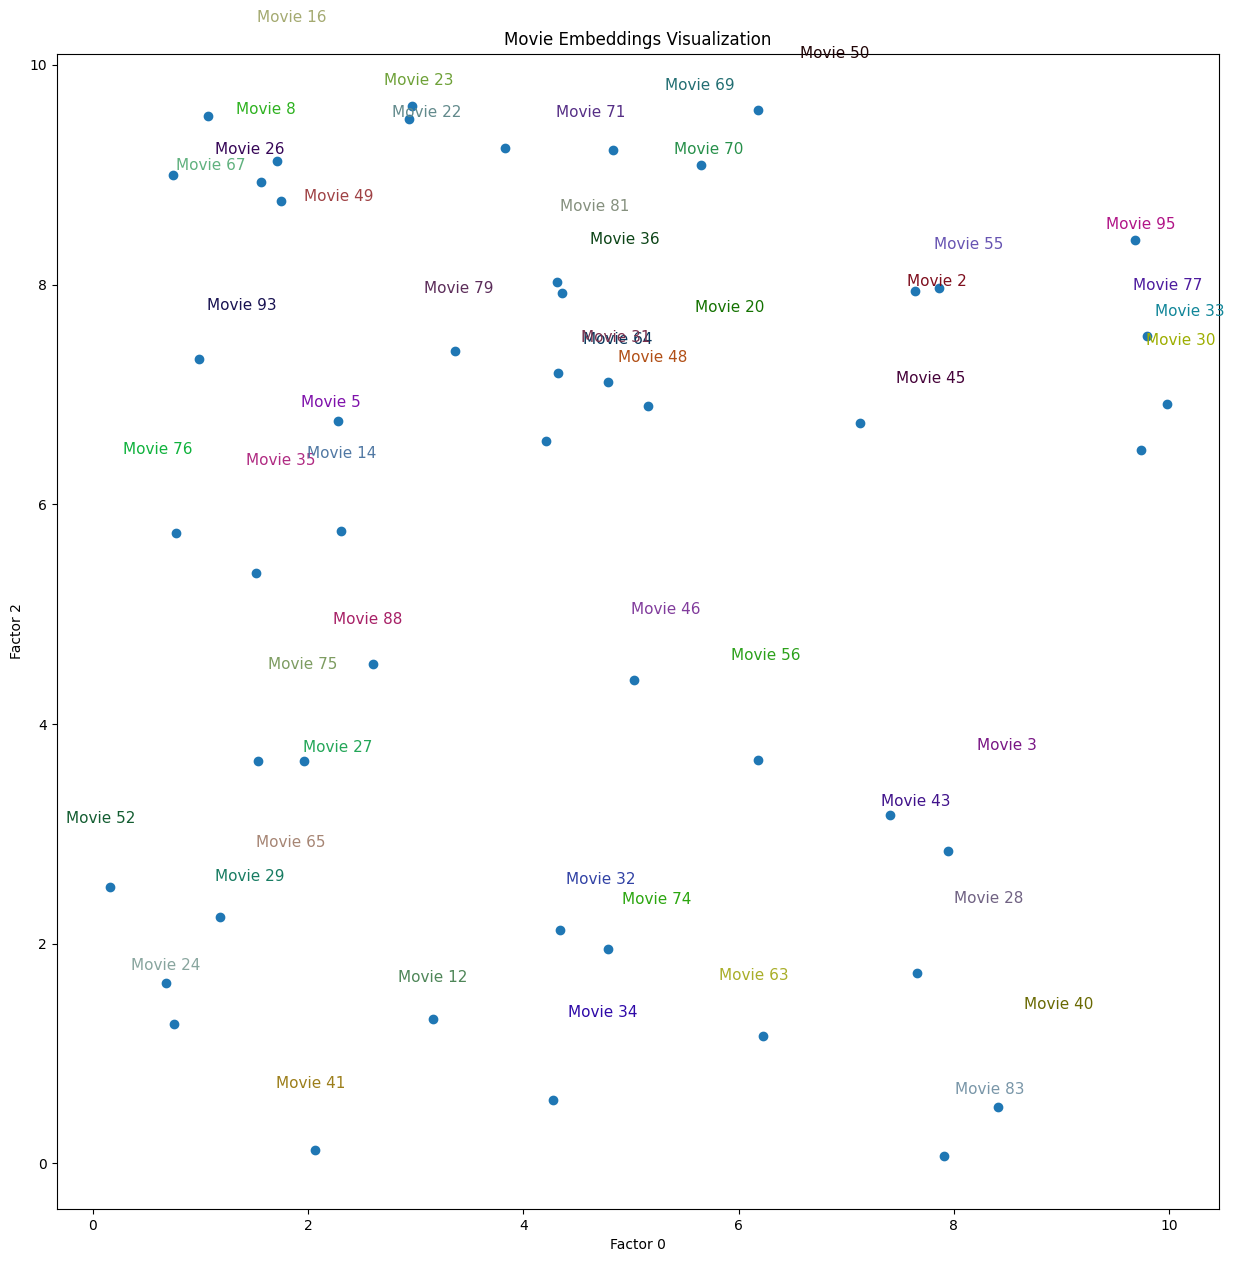

In [59]:
import numpy as np
import matplotlib.pyplot as plt

# ... (Sample Data as before)

num_movies_to_plot = min(50, len(top_movies))
idxs = np.random.choice(len(top_movies), num_movies_to_plot, replace=False)

X = fac0[idxs]
Y = fac2[idxs]

plt.figure(figsize=(15, 15))
plt.scatter(X, Y)

text_offsets_x = np.random.uniform(-0.5, 0.5, size=num_movies_to_plot)
text_offsets_y = np.random.uniform(0, 1, size=num_movies_to_plot)

# 5. Check Text Offsets:
print("Text offsets X:", text_offsets_x)
print("Text offsets Y:", text_offsets_y)

# Use enumerate to get the correct index
for j, (movie_name, x, y) in enumerate(zip(top_movies[idxs], X, Y)):  # Use enumerate
    print(f"Plotting movie: {movie_name} at ({x}, {y}) with offset ({text_offsets_x[j]}, {text_offsets_y[j]})")
    plt.text(x + text_offsets_x[j], y + text_offsets_y[j], movie_name, color=np.random.rand(3) * 0.7, fontsize=11)  # Use movie_name

plt.xlabel("Factor 0")
plt.ylabel("Factor 2")
plt.title("Movie Embeddings Visualization")
plt.show()

# Exercise 2

## Play around with different collaborative filtering model parameters such as n_factors and other parameters.
## Identify if any such parameters have impact on the speed of convergence or the performance on the model

In [35]:
#CODE

In [36]:
#startcodingorgeneratingwithAI